# Imports and setup

In [1]:
#Installing AIF360

!pip install 'aif360[all]'

In [2]:
#Installing tabulate for table generation

!pip install tabulate

In [3]:
#Imports:

import logging

from IPython.display import Markdown, display

import numpy as np

import pandas as pd

import seaborn as sns

from tabulate import tabulate


import pickle

#Matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

#Torch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

#Sklearn
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline

from collections import OrderedDict

import sys

# Fairness metrics
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric
from aif360.datasets import StandardDataset, BinaryLabelDataset

# Fairness preprocessing
from aif360.algorithms.preprocessing import Reweighing

/usr/local/lib/python3.10/dist-packages/torch/_functorch/deprecated.py:61: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.vmap is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.vmap instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html
  warn_deprecated('vmap', 'torch.vmap')


In [4]:
# Print library versions
print(f"numpy version: {np.__version__}")
print(f"pandas version: {pd.__version__}")
print(f"seaborn version: {sns.__version__}")
print(f"pickle version: {pickle.format_version}")
print(f"matplotlib version: {plt.matplotlib.__version__}")
print(f"torch version: {torch.__version__}")
print(f"Python version: {sys.version}")

numpy version: 1.25.2
pandas version: 2.2.1
seaborn version: 0.13.1
pickle version: 4.0
matplotlib version: 3.7.1
torch version: 2.1.0+cu121
Python version: 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]


In [5]:
# modify the directory for the "Full heart assignment3 " dataset containing the entire dataset
df = pd.read_csv("/content/heart_assignment2-W2024 (3).csv")

# Part 1 :  Fairness concerns

In [6]:
df.head()

,Age,Sex,Race,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,Asian,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,Other,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,Other,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,White,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,Other,NAP,150,195,0,Normal,122,N,0.0,Up,0


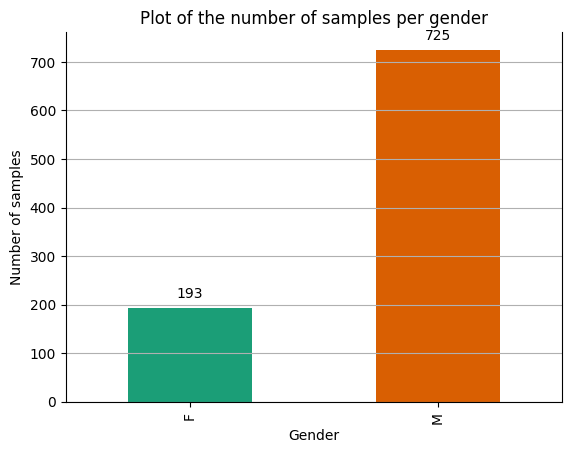

In [7]:
# Plot of the number of samples per gender


ax = df.groupby('Sex').size().plot(kind='bar', color=sns.palettes.mpl_palette('Dark2'))
ax.spines[['top']].set_visible(False)
ax.set_xlabel("Gender")
ax.set_ylabel("Number of samples")
ax.set_title("Plot of the number of samples per gender")

# Display exact numbers on top of each bar
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')


plt.grid(True, axis='y')
plt.show()

<ipython-input-8-0d14abd4e852>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax_disease = sns.countplot(x='Sex', data=df[df['HeartDisease'] == 1], palette='Dark2', ax=axes[0])
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
<ipython-input-8-0d14abd4e852>:19: FutureWarning: 

Passing `palette` 

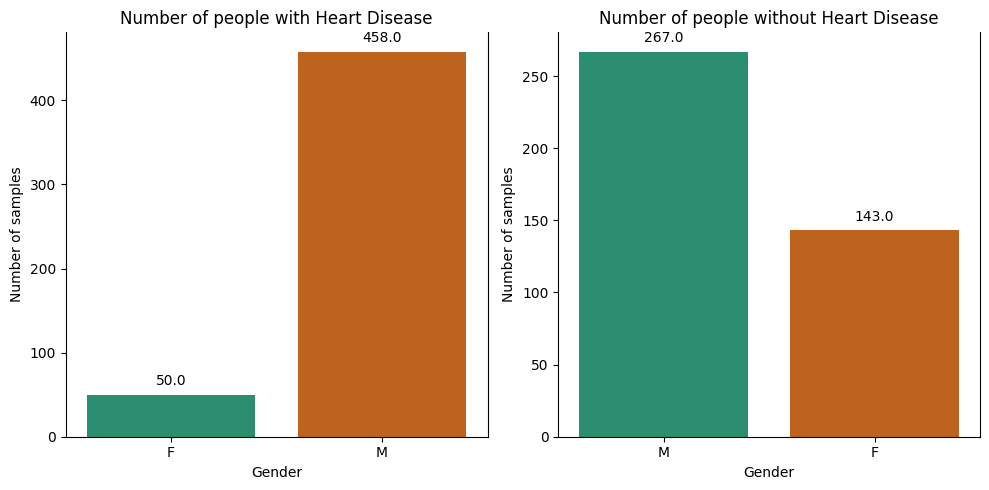

In [8]:
# Plot of the distribution of Heart disease accross both genders

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot for patients with heart disease
ax_disease = sns.countplot(x='Sex', data=df[df['HeartDisease'] == 1], palette='Dark2', ax=axes[0])
ax_disease.spines[['top']].set_visible(False)
ax_disease.set_xlabel("Gender")
ax_disease.set_ylabel("Number of samples")
ax_disease.set_title("Number of people with Heart Disease")

# Display exact numbers on top of each bar
for p in ax_disease.patches:
    ax_disease.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# Plot for patients without heart disease
ax_no_disease = sns.countplot(x='Sex', data=df[df['HeartDisease'] == 0], palette='Dark2', ax=axes[1])
ax_no_disease.spines[['top']].set_visible(False)
ax_no_disease.set_xlabel("Gender")
ax_no_disease.set_ylabel("Number of samples")
ax_no_disease.set_title("Number of people without Heart Disease")

# Display exact numbers on top of each bar
for p in ax_no_disease.patches:
    ax_no_disease.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                           ha='center', va='center', xytext=(0, 10), textcoords='offset points')


plt.tight_layout()
plt.show()


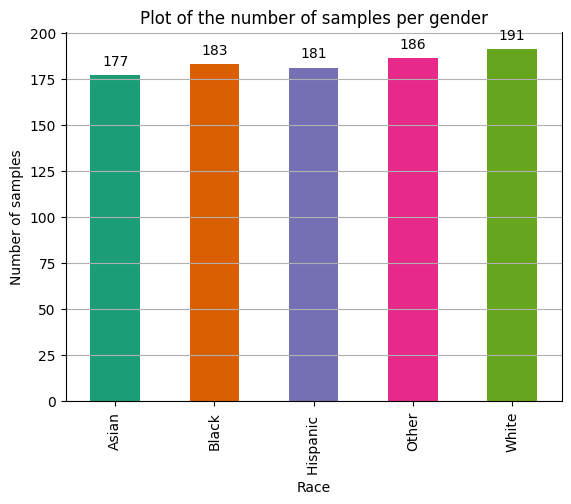

In [9]:
# Plot of the number of samples per race


ax = df.groupby('Race').size().plot(kind='bar', color=sns.palettes.mpl_palette('Dark2'))
ax.spines[['top']].set_visible(False)
ax.set_xlabel("Race")
ax.set_ylabel("Number of samples")
ax.set_title("Plot of the number of samples per gender")

# Display exact numbers on top of each bar
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')


plt.grid(True, axis='y')
plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


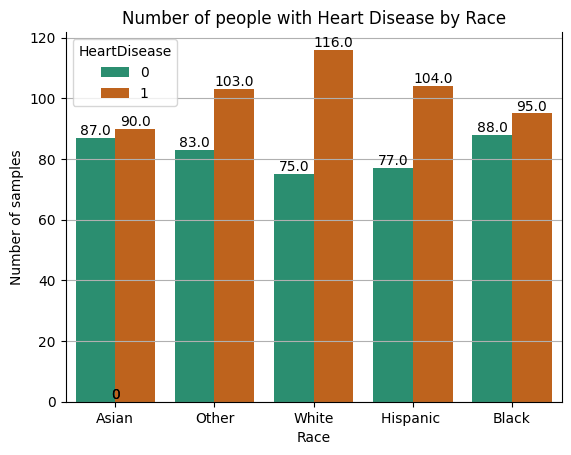

In [10]:
# Plot of the distribution of Heart disease accross all races

ax = sns.countplot(x='Race', hue='HeartDisease', data=df, palette='Dark2')
ax.spines[['top']].set_visible(False)
ax.set_xlabel("Race")
ax.set_ylabel("Number of samples")
ax.set_title("Number of people with Heart Disease by Race")

# Display exact numbers on top of each bar
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='top', xytext=(0, 10), textcoords='offset points')

# Display the plot
plt.grid(True, axis='y')
plt.show()

#Part 2 :  Fairness metrics

## Preprocessing

In [11]:
#Checking the types of the dataframe
print(df.dtypes)

Age                 int64
Sex                object
Race               object
ChestPainType      object
RestingBP           int64
Cholesterol         int64
FastingBS           int64
RestingECG         object
MaxHR               int64
ExerciseAngina     object
Oldpeak           float64
ST_Slope           object
HeartDisease        int64
dtype: object


In [12]:
#The mapping dictionnary we have created between categorical data and numerical data
# can be found here.

#Note: a discrepency of 2 can be found between the indices of the samples on the csv and the ones on the pd data frame.
#For example, sample 25 in the csv is sample 23 in the pd.Dataframe
#This is due to the fact that the first line of data in the csv is 2 (the first line of the csv being line [1]
# and being the title line, whereas the pd.Dataframe starts at line [0]).

Columns_to_change  = ['Sex', 'Race', 'ChestPainType', 'RestingECG',
       'ExerciseAngina', 'ST_Slope']
numerical_columns = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak', "HeartDisease"]

mapping_dict = {}
for c in Columns_to_change:
  df[c] = df[c].astype('category')
  mapping_dict[c] = dict(enumerate(df[c].cat.categories))
columns = df.select_dtypes(['category']).columns
df[columns] = df[columns].apply(lambda x: x.cat.codes)

# copy the data
df_scaled = df.copy()

# apply normalization techniques. This ensures that features with
# different scales contribute equally to model training, preventing dominance by features with larger magnitudes.

stad = StandardScaler()

for column in numerical_columns:
    if column != "HeartDisease":
        df_scaled[column] = stad.fit_transform(df_scaled[column].to_numpy().reshape(-1, 1))


df = df_scaled



In [13]:
mapping_dict

{'Sex': {0: 'F', 1: 'M'},
 'Race': {0: 'Asian', 1: 'Black', 2: 'Hispanic ', 3: 'Other', 4: 'White'},
 'ChestPainType': {0: 'ASY', 1: 'ATA', 2: 'NAP', 3: 'TA'},
 'RestingECG': {0: 'LVH', 1: 'Normal', 2: 'ST'},
 'ExerciseAngina': {0: 'N', 1: 'Y'},
 'ST_Slope': {0: 'Down', 1: 'Flat', 2: 'Up'}}

In [14]:
#Spliting the dataset into training and testing.
#It is also important to note that in our case, we are not actually building a prediction from our model
# Therefore, as we are not iterating over some "test" cases, we could also have split our dataset into only 3 sets : training, testing and validation.


X = df.drop('HeartDisease', axis = 1)
y = df['HeartDisease']
x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=42)


## Question 4

Creating model

In [15]:
print(f'original df size = {len(df)}')
print(f'X size = {len(X)}')
print(f'x_train size = {len(x_train)}')
print(f'x_test size = {len(x_test)}')
print(f'y_train size = {len(y_train)}')
print(f'y_test size = {len(y_test)}')

original df size = 918
X size = 918
x_train size = 688
x_test size = 230
y_train size = 688
y_test size = 230


Text(0.5, 1.0, 'Accuracy Score: 0.8608695652173913')

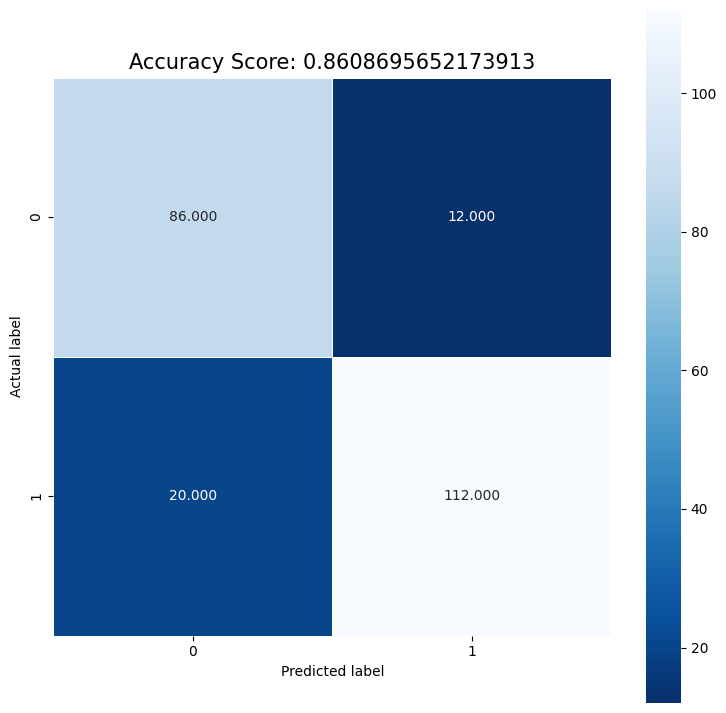

In [16]:
#Importing the sklearn Logistic Regression model
model = LogisticRegression(solver='liblinear', max_iter=10000)

#Fitting the model
model.fit(x_train, y_train)
predictions = model.predict(x_test) #Predicting heart diseases on the test data set
score = model.score(x_test, y_test) #scoring the performance of the model on the test data set
cm = metrics.confusion_matrix(y_test, predictions) #Creating the confusion matrix

#Plotting the confusion matrix
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15)

##Assess fairness using fairness metrics

In [17]:
# Metrics function. Code provided in the tutorial 7 : Fairness II.

def compute_metrics(dataset_true, dataset_pred,
                    unprivileged_groups, privileged_groups,
                    disp = True):
    """ Compute the key metrics """
    classified_metric_pred = ClassificationMetric(dataset_true,
                                                 dataset_pred,
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
    metrics = OrderedDict()
    metrics["Balanced accuracy"] = 0.5*(classified_metric_pred.true_positive_rate()+
                                             classified_metric_pred.true_negative_rate())
    metrics["Accuracy between unprivileged and privileged groups"] = classified_metric_pred.accuracy()
    metrics["Statistical parity difference"] = classified_metric_pred.statistical_parity_difference()
    metrics["Disparate impact"] = classified_metric_pred.disparate_impact()
    metrics["Average Odds Difference between unprivileged and privileged group"] = classified_metric_pred.average_odds_difference()
    metrics["Equal opportunity difference"] = classified_metric_pred.equal_opportunity_difference()
    metrics["Theil index"] = classified_metric_pred.theil_index()
    metrics["True Positive Rate difference between unprivileged and privileged groups"] = classified_metric_pred.true_positive_rate_difference()
    metrics["False Negative Rate ratio between unprivileged and privileged groups"] = classified_metric_pred.false_negative_rate_ratio()


    if disp:
        for k in metrics:
            print("%s = %.4f" % (k, metrics[k]))

    return metrics

In [18]:

# Creating DataFrames with features
real_values_df = x_test.join(y_test) #real values df is the original test dataset
predictions_df = real_values_df.copy()

#Creating the dataframe with the predictions
predictions_df['HeartDisease'] = predictions



#Highlighting the privileged group (1 : Male) from the unprivileged one (0 : F).
privileged_groups = [{'Sex': 1}]
unprivileged_groups = [{'Sex': 0}]



#Creating Datasets in the format of a BinaryLabelDataset
real_values_BLD = BinaryLabelDataset(df = real_values_df,
                               favorable_label = 1,
                               unfavorable_label = 0,
                               label_names = ['HeartDisease'],
                               protected_attribute_names = ['Sex'])

predictions_BLD = BinaryLabelDataset(df = predictions_df,
                               favorable_label = 1,
                               unfavorable_label = 0,
                               label_names = ['HeartDisease'],
                               protected_attribute_names = ['Sex'])

In [19]:
#Calculation of the metrics
metrics = compute_metrics(real_values_BLD, predictions_BLD,unprivileged_groups=unprivileged_groups,privileged_groups=privileged_groups)
metrics

Balanced accuracy = 0.8630
Accuracy between unprivileged and privileged groups = 0.8609
Statistical parity difference = -0.3404
Disparate impact = 0.4296
Average Odds Difference between unprivileged and privileged group = -0.1234
Equal opportunity difference = -0.2689
Theil index = 0.1103
True Positive Rate difference between unprivileged and privileged groups = -0.2689
False Negative Rate ratio between unprivileged and privileged groups = 3.0500


OrderedDict([('Balanced accuracy', 0.8630179344465059),
             ('Accuracy between unprivileged and privileged groups',
              0.8608695652173913),
             ('Statistical parity difference', -0.3404483823331991),
             ('Disparate impact', 0.4295996401259559),
             ('Average Odds Difference between unprivileged and privileged group',
              -0.12343172675957104),
             ('Equal opportunity difference', -0.26885245901639343),
             ('Theil index', 0.11033675738172087),
             ('True Positive Rate difference between unprivileged and privileged groups',
              -0.26885245901639343),
             ('False Negative Rate ratio between unprivileged and privileged groups',
              3.05)])

# Part 3 : Pre-processing for fairness (reweighting)

In [20]:
#Reweighting with respect to our privileged and unprivileged groups
rw = Reweighing(unprivileged_groups=unprivileged_groups,
               privileged_groups=privileged_groups)

#reweighting our previous Binary Label Dataset
rw.fit(real_values_BLD)
rw_df = rw.transform(real_values_BLD)
rw_df

               instance weights  features                           \
                                          protected attribute        
                                      Age                 Sex Race   
instance names                                                       
668                    0.573013  1.006537                 0.0  1.0   
30                     0.898503 -0.054192                 1.0  3.0   
377                    0.898503  1.218683                 1.0  4.0   
535                    0.898503  0.264027                 1.0  1.0   
807                    1.179458  0.051881                 1.0  4.0   
...                         ...       ...                 ...  ...   
259                    0.573013  0.157954                 0.0  2.0   
490                    0.898503  1.961193                 1.0  4.0   
302                    0.898503 -0.054192                 1.0  4.0   
7                      1.179458  0.051881                 1.0  1.0   
892                 

In [21]:
#Creating reweighted train-test sets
x_train_rw = rw_df.features
y_train_rw = rw_df.labels.ravel()
x_test_rw = real_values_BLD.features
y_test_rw = real_values_BLD.labels

#Implementing a logistic regression model
model = LogisticRegression()
model.fit(x_train_rw, y_train_rw, sample_weight=rw_df.instance_weights)

#creating a set or reweighted predictions set from our model
rw_predictions = model.predict(x_test)
rw_test_df = real_values_df.copy()
rw_test_df['HeartDisease'] = rw_predictions


#Creating a Binary Label Dataset from our predictions
rw_predicted_data =  BinaryLabelDataset(df = rw_test_df,
                               favorable_label = 1,
                               unfavorable_label = 0,
                               label_names = ['HeartDisease'],
                               protected_attribute_names = ['Sex'])


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


In [22]:
#Calculation of reweighted the metrics
rw_metrics = compute_metrics(real_values_BLD, rw_predicted_data,unprivileged_groups=unprivileged_groups,privileged_groups=privileged_groups)
rw_metrics

Balanced accuracy = 0.8400
Accuracy between unprivileged and privileged groups = 0.8435
Statistical parity difference = -0.2280
Disparate impact = 0.6279
Average Odds Difference between unprivileged and privileged group = -0.0231
Equal opportunity difference = -0.1770
Theil index = 0.1085
True Positive Rate difference between unprivileged and privileged groups = -0.1770
False Negative Rate ratio between unprivileged and privileged groups = 2.4400


OrderedDict([('Balanced accuracy', 0.8399814471243043),
             ('Accuracy between unprivileged and privileged groups',
              0.8434782608695652),
             ('Statistical parity difference', -0.2279500604107934),
             ('Disparate impact', 0.6278763971071664),
             ('Average Odds Difference between unprivileged and privileged group',
              -0.02305732379711785),
             ('Equal opportunity difference', -0.17704918032786887),
             ('Theil index', 0.10849260217460012),
             ('True Positive Rate difference between unprivileged and privileged groups',
              -0.17704918032786887),
             ('False Negative Rate ratio between unprivileged and privileged groups',
              2.44)])

In [23]:
# Convert dictionaries to a list of tuples
data = [(key,
         round(rw_metrics[key], 2),
         round(metrics[key], 2),
         f'{round(((metrics[key] - rw_metrics[key]) / rw_metrics[key]) * 100, 2)}%'
        ) for key in rw_metrics]

# Create a table using tabulate
table = tabulate(data, headers=['Metric', 'reweighted_metrics_classifier', 'metrics_classifier', 'percentage difference'], tablefmt='fancy_grid')

# Print the table
print(table)

╒══════════════════════════════════════════════════════════════════════════╤═════════════════════════════════╤══════════════════════╤═════════════════════════╕
│ Metric                                                                   │   reweighted_metrics_classifier │   metrics_classifier │ percentage difference   │
╞══════════════════════════════════════════════════════════════════════════╪═════════════════════════════════╪══════════════════════╪═════════════════════════╡
│ Balanced accuracy                                                        │                            0.84 │                 0.86 │ 2.74%                   │
├──────────────────────────────────────────────────────────────────────────┼─────────────────────────────────┼──────────────────────┼─────────────────────────┤
│ Accuracy between unprivileged and privileged groups                      │                            0.84 │                 0.86 │ 2.06%                   │
├───────────────────────────────────────